In [11]:
import numpy as np
import pandas as pd
import datetime as dt
import psycopg2
import pipeline_plan_functions.utils.pipe_db_handler as dbh
from python_utils.utils.logger import logger
import alloc_functions.controller as acf
import alloc_functions.feasibility_functions as ff
import pipeline_plan_functions.utils.data_handler as dh
import matplotlib.pyplot as plt
import matplotlib
from pulp import *

# import plotly.graph_objects as go
mapbox_token = ('pk.eyJ1Ijoic29mZmZ0IiwiYSI6ImNrbmZ0Z3RidzJ5NngycXA5cDNpY2c1ajIifQ.Gi2oP1Z3G5wP6pn7OF5l1A')

# HGV Feasibility Analysis
This Notebook analyses routes generated from telematics data for Heavy Goods Vehicles operating out of depots across the country. The aim is to model the energy requirements of the operations at each depot and evaluate how feasible it is to change those vehicles (currently diesel) to electric alternatives.

The first part of this analysis aims to create a clean set of routes for each depot. The second part looks at the EV feasibility at each depot

This analysis starts with routes that have already been generated by the telematics process. The routes have been filtered so each route is < 10 hours and <400 miles.

This process also requires the vehicles to be already in t_vehicles with the correct spec ID, and the sites to be in t_sites. This process usually occurs at the beginning of the project, before/during the telematics cleanup process. The vehicle data comes from the client's asset register.

## Part 1: Routes and Vehicle Duties
A vehicle duty refers to a combination of routes that happens roughly in a day. This isn't very well defined since the routes don't have strict daily operations; for example, they may work all through the night. However, there is some benefit in grouping "a day's worth of operations"

The first cell sets up some basic global variables and gets useful data from the database

In [41]:

# Modify this manually, which are the sites you want to look at
site_list = [  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
             20,  21,  23, 28]  # all depot site IDs
OUTPUT_FOLDER = 'template'
RUN_ID = 220
cnx = dbh.create_alch_engine()
# This gets a dictionary of site IDs -> names
# Note that I'm using client_id = 2 (Argos) instead of 3(Sainsbury's)
# because Sainsbury's owens Argos and the sites are unfortunately under Argos in
# our database
site_dict = ff.get_site_name_dict(2)
# Get a dictionary of vehicle IDs to specifications
sql_query = f"SELECT * FROM t_vehicles WHERE client_id=2"
vehicle_df = pd.read_sql_query(sql_query, con=cnx, index_col='vehicle_id')
cnx.dispose()
vehicle_spec_dict = vehicle_df['spec_id'].to_dict()

# Create vehicle specification table for diesel and electric
specs = tuple(np.arange(101, 111))  # The selection will depend on the project
vehicle_specifications = ff.find_vehicle_spec(specs)
vehicle_specifications['kwh_mile'] = 0
vehicle_specifications['diesel_l_mile'] = 0
elec_vehicles = vehicle_specifications['fuel_type'] == 'electric'
diesel_vehicles = vehicle_specifications['fuel_type'] == 'diesel'
vehicle_specifications.loc[elec_vehicles, 'kwh_mile'] = vehicle_specifications.loc[elec_vehicles, 'energy_use']
vehicle_specifications.loc[diesel_vehicles, 'diesel_l_mile'] = vehicle_specifications.loc[diesel_vehicles, 'energy_use']
hgv_drive = vehicle_specifications['energy_use'].to_dict()

### Get routes

In [13]:
# Get routes
cnx = dbh.create_alch_engine()
try:
    sql_query = f"SELECT * FROM t_route_master WHERE client_id = 3"
    routes = pd.read_sql_query(sql_query, con=cnx)
finally:
    cnx.dispose()
routes['spec_id'] = routes['vehicle_id'].map(vehicle_spec_dict)
# We only want to look at specific types of vehicles in this case
good_specs = {101: '4x2 rigid',
              102: '6x2 rigid',
              103: '4x2 tractor',
              104: '6x2 tractor'}
routes = routes[routes['spec_id'].isin(good_specs.keys())].copy()
routes['same_return'] = routes['site_id_start'] == routes['site_id_end']
routes['start_right_id'] = False
routes['duration_hours'] = (routes['arrival_time'] - routes['departure_time']).dt.total_seconds()/3600
routes['date'] = routes['departure_time'].dt.date
routes['start_time'] = (routes['departure_time'] - dt.datetime(2022, 1, 1)).dt.total_seconds()/3600 % 24
routes['end_time'] = (routes['arrival_time'] - dt.datetime(2022, 1, 1)).dt.total_seconds()/3600 % 24

### Daily duties
Here we group routes into daily duties, based on a waiting time of 4 hours (can be adjusted). So when a vehicle doesn't move for 4 hours or more, we take that to mean a new daily duty has started

In [20]:
duty_wait_time = dt.timedelta(hours=4)
routes.sort_values(by=['vehicle_id', 'departure_time'],
                        inplace=True)
routes['prev_wait_time'] = (routes['departure_time'] - routes['arrival_time'].shift(1))
routes['new_vehicle'] = routes['vehicle_id'] != routes['vehicle_id'].shift(1)
routes['new_duties'] = ((routes['new_vehicle']) | (routes['prev_wait_time'] > duty_wait_time))
routes['duty_id'] = routes['new_duties'].cumsum()

daily_duties = routes.groupby(['duty_id']).agg({
    'departure_time': 'min',
    'site_id_start': ['first', 'nunique'],
    'distance_miles': 'sum',
    'duration_hours': 'sum',
    'number_order': 'sum',
    'arrival_time': 'max',
    'route_id': 'count',
    'site_id_end': 'last',
    'spec_id': 'mean',
    'vehicle_id': 'mean',
    'date': 'first',
    'start_time': 'min',
    'end_time': 'max'})
daily_duties.columns = ['departure_time', 'site_id_start', 'number_sites', 'distance_miles',
                        'route_hours', 'number_order', 'arrival_time', 'n_routes', 'site_id_end',
                        'spec_id', 'vehicle_id', 'date', 'start_time', 'end_time']
daily_duties['same_return'] = daily_duties['site_id_start'] == daily_duties['site_id_end']
daily_duties['duty_duration'] = (daily_duties['arrival_time'] - daily_duties['departure_time']).dt.total_seconds()/3600

duties_selection_dict = {
    'departure_time': 'min',
    'site_id_start': ['first', 'nunique'],
    'distance_miles': 'sum',
    'duration_hours': 'sum',
    'arrival_time': 'max',
    'route_id': 'count',
    'site_id_end': 'last',
    'spec_id': 'mean',
    'vehicle_id': 'mean',
    'date': 'first',
    'start_time': 'min',
    'end_time': 'max'}

### Specific Site Routes
We need to assign routes to each depot. This is complicated by the fact that the there is considerable movement of vehicles between the depots. The goal is to identify vehicles that operate "mostly" out of a depot.

In [45]:
def get_site_frequent_vehicles(daily_duties, site, same_return_threshold=0.95):
    """Generates a specific route set for a site, based on vehicles that frequent that site"""
    daily_duties_site = daily_duties[daily_duties['site_id_start'] == site]
    # same_return means that the daily duty starts and ends on the same depot
    vehicle_return_duty_pc = daily_duties_site.groupby(['spec_id', 'vehicle_id']).agg({
        'same_return': 'mean',
        'date': 'nunique'})
    # This finds the vehicles that are almost always returning to that specific depot
    vehicle_high_return = (
        (vehicle_return_duty_pc['same_return'] > same_return_threshold)
        & (vehicle_return_duty_pc['date'] > vehicle_return_duty_pc['date']/3))
    array_return_pc = []
    labels = []
    for s in [101, 102, 103, 104]:
        if s in vehicle_return_duty_pc.index.get_level_values(0).unique():
            array_return_pc.append(100*vehicle_return_duty_pc.loc[s, 'same_return'].values)
            labels.append(good_specs[s])
    ff.violin_plot(array_return_pc, "duties per vehicle", site_dict[site],
                   labels=labels, suff="_duties", folder=OUTPUT_FOLDER)
    print(f"% duties returning to site: {daily_duties_site['same_return'].mean()}")

    ### Filter vehicle duties and routes
    vehicles_to_use = vehicle_high_return[vehicle_high_return].index.get_level_values(1)
    return vehicles_to_use

def get_site_routes(routes, daily_duties, vehicles):
    """Gets all the routes and daily vehicle duties done by a set of vehicles"""
    cols_routes = ['site_id_start', 'departure_time', 'arrival_time',
        'vehicle_id', 'distance_miles', 'route_id', 'site_id_end', 'spec_id',
        'duration_hours', 'date', 'start_time', 'end_time', 'prev_wait_time',
        'new_duties', 'duty_id']
    routes_vehicle_selection = routes[routes['vehicle_id'].isin(vehicles)][cols_routes]
    duties_vehicle_selection = daily_duties[daily_duties['vehicle_id'].isin(vehicles)]
    n_vehicles_route_start = routes[routes['site_id_start'] == site]['vehicle_id'].nunique()
    n_vehicles_site_final = len(vehicles)
    print(
        f"""Start with {n_vehicles_route_start} vehicles showing up in {site_dict[site]},
        {n_vehicles_site_final} final count"""
    )
    return routes_vehicle_selection, duties_vehicle_selection

def breakup_duties(routes, duties,
                   duty_hour_threshold = 25, duty_hour_min = dt.timedelta(hours=24)):
    """Break-up the daily vehicle duties that are too long based on longest break times at depot

    """
    new_duties = duties.copy()
    n_duties = len(new_duties)
    long_duties = new_duties[new_duties['duty_duration'] > duty_hour_threshold].index.values
    breakup_duties = len(long_duties) > 0
    duty_route_cols = ['site_id_start', 'prev_wait_time', 'new_duties', 'departure_time']
    logger.info(f"{len(long_duties)} out of {len(new_duties)} are long duties")
    while breakup_duties:
        for duty in long_duties[:]:
            duty_routes = routes[routes['duty_id'] == duty][duty_route_cols]
            elapsed_time = duty_routes['departure_time'] - duty_routes['departure_time'].min()
            time_difference = (elapsed_time - duty_hour_min).dt.total_seconds().abs()
            # Finds possible routes to use as break point
            possible_break_routes = (
                (duty_routes['site_id_start'] == site)
                & (~duty_routes['new_duties']))
            if possible_break_routes.any():
                # Finds the longest break point
                break_route = time_difference.loc[possible_break_routes].idxmin()
                routes.loc[break_route, 'new_duties'] = True

        routes['duty_id'] = routes['new_duties'].cumsum()
        new_duties = routes.groupby(['duty_id']).agg(duties_selection_dict)
        new_duties.columns = ['departure_time', 'site_id_start', 'number_sites', 'distance_miles',
                                'route_hours', 'arrival_time', 'n_routes', 'site_id_end',
                                'spec_id', 'vehicle_id', 'date', 'start_time', 'end_time']
        new_duties['duty_duration'] = (
            new_duties['arrival_time'] - new_duties['departure_time']
            ).dt.total_seconds()/3600
        long_duties = new_duties[new_duties['duty_duration'] > duty_hour_threshold].index.values
        logger.info(f"{len(long_duties)} out of {len(new_duties)} are long duties")
        new_duties['same_return'] = new_duties['site_id_start'] == new_duties['site_id_end']
        # Stop the cycle if there are no more long duties or the process is no longer effective
        if (len(new_duties) == n_duties) | (len(long_duties) == 0):
            breakup_duties = False
    daily_duties_site = new_duties[
        (new_duties['site_id_start'] == site)
        & (new_duties['site_id_end'] == site)]
    return daily_duties_site

def upload_route_allocations(duties, routes, first_alloc_id, hgv_drive):
    """Uploads the new routes as new vehicle allocations based on vehicle spec
    """
    cols_routes = ['duty_id', 'route_id', 'date', 'spec_id',
                   'distance_miles', 'vehicle_id']
    cols_routes_new = ['duty_id', 'route_id', 'date', 'allocated_spec_id',
                       'distance_miles', 'allocated_vehicle_id']
    base_alloc = {
        'run_id': RUN_ID,
        'xmpg_change': 0,
        'allocated': 'c',
        'charger1': 0,
        'charger2': 0,
        'num_charger1': 0,
        'num_charger2': 0,
        'vehicle_pool': '[]',
        'route_table': 't_route_master',
        'xmpg': 1,
        'allocation_score': 0,
        'vcategory': 'Fossil Fuel',
        'overnight_error': 0,
        'schedule_charge': 2,
        'source': 1
    }
    for i in range(4):
        # Separates the routes based on the type of vehicle
        spec = 101 + i
        allocation_id = first_alloc_id + i

        duties_spec = duties[duties['spec_id'] == spec]
        if len(duties_spec) > 0:
            routes_spec = routes[routes['duty_id'].isin(duties_spec.index)][cols_routes]
            # routes_spec.reset_index(inplace=True)
            routes_spec.columns = cols_routes_new
            routes_spec['allocation_id'] = allocation_id
            routes_spec['shift'] = 1
            routes_spec['diesel_fuel_consumption'] = (
                routes_spec['distance_miles'] * hgv_drive[spec])
            routes_spec.drop(columns=['distance_miles'], inplace=True)
            spec_alloc = {
                'allocation_id': allocation_id,
                'site_id': site,
                'start_date': str(routes_spec['date'].min()),
                'end_date': str(routes_spec['date'].max() + dt.timedelta(days=1)),
                'vehicle1': spec,
                'vehicle2': spec,
                'num_r': len(routes_spec),
                'num_v': len(routes_spec['allocated_vehicle_id'].unique()),
                'num_v_final': len(routes_spec['allocated_vehicle_id'].unique()),
                'num_vehicle1': len(routes_spec['allocated_vehicle_id'].unique()),
                'num_vehicle2': 0,
                'n_duties': len(duties_spec)
            }
            alloc = {**base_alloc, **spec_alloc}
            ff.upload_dict_to_db(alloc, connection, cur)
            dbh.upload_table(routes_spec, 't_route_allocated')
            print(f"Finished alloc {allocation_id} with spec {spec}")
    return allocation_id + 1

2022-09-26 17:19:18|DEBUG|controller.py(52)|get_fps_allocation_id|reading last allocation ID
2022-09-26 17:19:19|INFO|1548861554.py(6)|<module>|Site: 1 - Waltham Point DC
2022-09-26 17:19:19|INFO|535620487.py(50)|breakup_duties|1692 out of 7225 are long duties


% duties returning to site: 0.9828687967369136
Start with 497 vehicles showing up in Waltham Point DC,
        137 final count


2022-09-26 17:19:30|INFO|535620487.py(72)|breakup_duties|570 out of 8917 are long duties
2022-09-26 17:19:34|INFO|535620487.py(72)|breakup_duties|193 out of 9487 are long duties
2022-09-26 17:19:36|INFO|535620487.py(72)|breakup_duties|58 out of 9680 are long duties
2022-09-26 17:19:36|INFO|535620487.py(72)|breakup_duties|26 out of 9738 are long duties
2022-09-26 17:19:36|INFO|535620487.py(72)|breakup_duties|7 out of 9764 are long duties
2022-09-26 17:19:37|INFO|535620487.py(72)|breakup_duties|3 out of 9771 are long duties
2022-09-26 17:19:37|INFO|535620487.py(72)|breakup_duties|0 out of 9774 are long duties
2022-09-26 17:19:38|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_route_allocated


Finished alloc 831 with spec 101


2022-09-26 17:19:39|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_route_allocated


Finished alloc 832 with spec 102


2022-09-26 17:19:40|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_route_allocated


Finished alloc 833 with spec 103


2022-09-26 17:19:44|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_route_allocated


Finished alloc 834 with spec 104


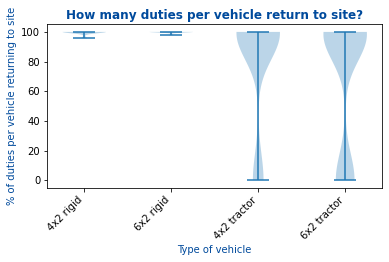

In [49]:
connection, cur = dbh.database_connection('test')
# Finds the next available allocation_id
first_alloc_id = acf.get_fps_allocation_id(connection, cur) + 1
alloc_id = first_alloc_id
for site in site_list[:1]:
    logger.info(f'Site: {site} - {site_dict[site]}')
    # Get the routes assigned to that site
    site_vehicles = get_site_frequent_vehicles(daily_duties, site)
    site_routes, site_duties = get_site_routes(routes, daily_duties, site_vehicles)
    site_duties = breakup_duties(site_routes, site_duties)
    # Upload routes to database
    alloc_id = upload_route_allocations(site_duties, site_routes,
                                        alloc_id, hgv_drive)
cur.close()
connection.close()

## Part 2: Feasibility Analysis

This part looks at the each of the route allocations created before and evaluates their feasibility against an EV counterpart. Once the allocations are created for the EV options, usually we move on to the charging module to create charging profiles. However, this is enough for the feasiblity analysis part of the project

In [ ]:
# Find the first available allocation id
first_ev_alloc = acf.get_fps_allocation_id(connection, cur) + 1

# This is not ideal, but it's a way of converting the diesel specification IDs
# to their equivalent electric counterparts
# ev_spec_id : [diesel_allocation_id, ev_allocation_id, diesel_spec_id]
ev_allocation_dict = {
    111: [first_alloc_id, first_ev_alloc, 101],
    112: [first_alloc_id + 1, first_ev_alloc + 1, 102],
    113: [first_alloc_id + 2, first_ev_alloc + 2, 103],
    114: [first_alloc_id + 3, first_ev_alloc + 3, 104],
}
for ev_spec in ev_allocation_dict.keys():
    allocation, new_allocation = ev_allocation_dict[ev_spec][0], ev_allocation_dict[ev_spec][1]
    diesel_spec = ev_allocation_dict[ev_spec][2]
    try:
        alloc = ff.find_allocation(allocation)
        assert diesel_spec == alloc['vehicle1'], f"Wrong allocation ID, spec {alloc['vehicle1']} != {diesel_spec}"
        # Calculates daily vehicle requirements based on the daily duties
        routes_spec, grouped_spec = ff.allocation_grouping(
            alloc,
            vehicle_specifications.loc[ev_spec, 'energy_use'],
            vehicle_specifications.loc[ev_spec, 'charge_power_ac'],
            vehicle_specifications.loc[ev_spec, 'charge_power_dc'],
            connection, cur)
        # Calculates the feasbility of each daily duty against a specific EV option
        ff.calculate_feasibility(
            grouped_spec,
            vehicle_specifications.loc[ev_spec, 'quoted_range_mile'])
        ev_vehicle_map = ff.ev_feasibility_dict(grouped_spec, ev_spec)
        grouped_spec['allocated_spec_id'] = grouped_spec['allocated_vehicle_id'].map(ev_vehicle_map)
        routes_spec['allocated_spec_id'] = routes_spec['allocated_vehicle_id'].map(ev_vehicle_map)
        # Uploads the set of routes but now with the EV option instead of the diesel option
        ff.upload_ev_routes(routes_spec,
                        vehicle_specifications['kwh_mile'].to_dict(),
                        vehicle_specifications['diesel_l_mile'].to_dict(),
                        new_allocation)
        # Calculate the number of EV vehicles
        veh1_ids = [key for key in ev_vehicle_map.keys()
            if ev_vehicle_map[key] == ev_spec]
        # Calculate the number of DC chargers required
        number_dc_max = grouped_spec.groupby('date').sum()['feasible_withdc'].max()
        number_dc = min(number_dc_max, len(veh1_ids))
        feasibility_count = grouped_spec[['feasible_nois', 'feasible_withac',
                                          'feasible_withdc', 'unfeasible_withdc']].sum()
        # Creates a new allocation row for the EV scenario
        new_alloc = ff.upload_new_allocation(
            alloc, new_allocation, routes_spec, ev_vehicle_map,
            vehicle_specifications.loc[ev_spec, 'charge_power_ac'],
            vehicle_specifications.loc[ev_spec, 'charge_power_dc'],
            number_dc, feasibility_count, connection, cur)
        print(f"Finished alloc {new_allocation} with spec {ev_spec}")
    except Exception as e:
        print(f"Not possible to do allocation {allocation} - {new_allocation}")
        print(e)